<center>

# **Covid by County** #
#### **Introduction to Data Science** ####
    
Team 4 Contributors: Gloria Ni, Jun Bae, Joshua Lee, Yuna Lee, Patrick Elizondo

### Comments and Grade: A (95/100) ###
- Highlights:
  - You merged 3 datasets together and created meaningful and interpretable features. 
You did tons of data exploration and visualization. 
  - Great job creating the 7-day moving average plots function. 
  - Your plots are well designed and effective in conveying the message.
  - Your interpretation of PCA is very creative: create a binary indicator based on a numerical variable and color code the PCA scatter plot. 
  - Your code is modular, organized into functions, and sufficiently commented. 
  - You incorporated a full linear regression model that reduced RMSE by half from your simple KNN regression. 
- Improvements:
  - Small technical issue: for your PCA, since your variables are on drastically different scales, it is probably more appropriate to first standardize the columns. Right now, it is clear that the first 2 PCs are just ones with the largest scale, so population and covid cases. 
  - There are multiple versions of data, which I think can be further cleaned up. 
  - A small bug in your code: you did not specify K in KNN so it returned an error.
  - Can we have some interpretation of the linear regression coefficients? Which is the most important factor in predicting the covid infection rates?


# **Introduction** #

All U.S. residents have most likely been affected by Covid in some way, whether in having personally contracted the disease or knowing someone who was infected, or just being limited by everyday restrictions. As part of the global response to the ongoing Coronavirus Pandemic, we have assessed the primary factors that highly impact Covid infection rate. There are many arguments as to what factors cause high Covid case numbers in each county. So in response to this pandemic, we analyzed the relationship between such factors and Covid cases per county. To explore, we used demographic data, including population density and socioeconomic vulnerability.


In [ ]:
# Standard Imports

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["patch.force_edgecolor"] = True

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Mount the drive to Google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Read data, create dataframes, and clean data** #



First, read in and clean the SVI data

In [ ]:
# Read in the SVI data
SVI2018 = pd.read_csv('/content/drive/Shareddrives/DSCI101Fa21Team4/SVI2018_US_COUNTY.csv')

# Select the columns we want to keep
col_select = ['STATE', 'ST_ABBR', 'COUNTY', 'FIPS', 'LOCATION', 'AREA_SQMI', 'E_TOTPOP',
              'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP','EP_AGE65', 'EP_DISABL','EP_SNGPNT', 'EP_MINRTY','EP_NOVEH', 
             'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3',  'RPL_THEME4']
SVI = SVI2018[col_select]

# Rename the columns to be informative
name_dic = {'AREA_SQMI':'area', 'E_TOTPOP':'population', 'EP_POV':'below poverty', 'EP_UNEMP':'unemployment', 'EP_PCI':'per capita income', 'EP_NOHSDP':'no high school diploma',
            'EP_AGE65':'age 65 above', 'EP_DISABL':'disabled','EP_SNGPNT':'single parent', 'EP_MINRTY':'minority','EP_NOVEH':'no vehicle', 
             'RPL_THEME1':'Socioeconomic Index', 'RPL_THEME2':'Household Composition Index', 'RPL_THEME3':'Minority Index',  'RPL_THEME4':'Housing Transportation Index'}
SVI.rename(columns=name_dic, inplace=True)

# Check for missing values: the -999 are missing values
#SVI2018.isna().sum()
# Code missing values properly
SVI.replace({-999: np.NaN}, inplace=True)

# Fix the FIPS field, convert to string for merging, standard FIPS should be 5 digit code
SVI['FIPS'] = SVI['FIPS'].astype(int).astype(str).str.rjust(5, fillchar='0')
SVI.head()

,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,area,population,below poverty,unemployment,per capita income,no high school diploma,age 65 above,disabled,single parent,minority,no vehicle,Socioeconomic Index,Household Composition Index,Minority Index,Housing Transportation Index
0,NEW MEXICO,NM,Rio Arriba,35039,"Rio Arriba County, New Mexico",5860.869195,39307,NaN,NaN,NaN,13.8,18.0,16.1,10.7,87.5,6.2,NaN,0.8758,0.9268,0.5409
1,ALABAMA,AL,Autauga,01001,"Autauga County, Alabama",594.443459,55200,15.4,4.2,29372.0,11.3,14.6,19.3,7.5,25.0,5.6,0.3631,0.5810,0.5947,0.3741
2,ALABAMA,AL,Blount,01009,"Blount County, Alabama",644.830460,57645,14.4,4.1,22656.0,19.8,17.8,14.2,7.0,12.9,4.2,0.6143,0.3187,0.5915,0.1741
3,ALABAMA,AL,Butler,01013,"Butler County, Alabama",776.838201,20025,23.5,6.7,20430.0,15.4,19.0,17.7,10.5,48.1,7.8,0.8455,0.9077,0.6447,0.6259
4,ALABAMA,AL,Calhoun,01015,"Calhoun County, Alabama",605.867251,115098,18.6,8.8,24706.0,15.9,16.8,20.8,10.4,27.5,5.8,0.7866,0.8303,0.6507,0.6492


Next, read in and clean the mask usage data

In [ ]:
# Read in the mask usage data
mask = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')
# Checked for missing values: no missing values
#mask.dtypes
# Fix the fips to be standard format
mask['COUNTYFP'] = mask['COUNTYFP'].astype(str).str.rjust(5, fillchar='0')
# Make column names lower case
mask.columns = mask.columns.str.lower()

mask.head()

,countyfp,never,rarely,sometimes,frequently,always
0,01001,0.053,0.074,0.134,0.295,0.444
1,01003,0.083,0.059,0.098,0.323,0.436
2,01005,0.067,0.121,0.120,0.201,0.491
3,01007,0.020,0.034,0.096,0.278,0.572
4,01009,0.053,0.114,0.180,0.194,0.459


Lastly, read in and clean the Covid cases data

In [ ]:
# Read in Covid data
covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
# Drop rows with missing fips
covid.dropna(subset=['fips'], inplace=True)
# Missing death filled with 0
covid.fillna(value=0, inplace=True)
covid.isna().sum()
# Fix the fips to be standard format
covid['fips'] = covid['fips'].astype(int).astype(str).str.rjust(5, fillchar='0')
# Pick a date for the number of cases
select_date = '2020-11-01'
covid_date = covid[covid['date']==select_date]

covid.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


# **Aggregate data by merging dataframes** #

First, merge the SVI dataframe with the mask dataframe

In [ ]:
# SVI merge with mask
county_svi = SVI.merge(mask, how='outer', left_on='FIPS', right_on='countyfp')
# check for NaN
county_svi.isna().sum()
# only 1 missing in some of the columns, check which one
county_svi[county_svi['unemployment'].isna()]
# turns out to be the Rio Arriba county in the SVI data which had -999 values
# Ok to drop since it is just one county, however it does have some other columns, keep for now
#county_svi.dropna(inplace=True)
# drop duplicate column for fips
county_svi.drop(columns=['countyfp'], inplace=True)
# create new column population density
county_svi['population density'] = county_svi['population'] / county_svi['area']
# Expressed the mask uasge numerically. The higher number of mask score, the lower usage of mask: 
# I think this should be reversed, higher mask score means more usage of mask, right?
# this makes sure the score is between 1 to 5, with 1 being nobody uses mask, and 5 being everyone uses mask all the time
county_svi["mask score"] = county_svi["never"]*1 + county_svi["rarely"]*2 + county_svi["sometimes"]*3 + county_svi["frequently"]*4 + county_svi["always"]*5
county_svi.head()

,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,area,population,below poverty,unemployment,per capita income,no high school diploma,age 65 above,disabled,single parent,minority,no vehicle,Socioeconomic Index,Household Composition Index,Minority Index,Housing Transportation Index,never,rarely,sometimes,frequently,always,population density,mask score
0,NEW MEXICO,NM,Rio Arriba,35039,"Rio Arriba County, New Mexico",5860.869195,39307,NaN,NaN,NaN,13.8,18.0,16.1,10.7,87.5,6.2,NaN,0.8758,0.9268,0.5409,0.007,0.054,0.102,0.162,0.675,6.706684,4.444
1,ALABAMA,AL,Autauga,01001,"Autauga County, Alabama",594.443459,55200,15.4,4.2,29372.0,11.3,14.6,19.3,7.5,25.0,5.6,0.3631,0.5810,0.5947,0.3741,0.053,0.074,0.134,0.295,0.444,92.859967,4.003
2,ALABAMA,AL,Blount,01009,"Blount County, Alabama",644.830460,57645,14.4,4.1,22656.0,19.8,17.8,14.2,7.0,12.9,4.2,0.6143,0.3187,0.5915,0.1741,0.053,0.114,0.180,0.194,0.459,89.395591,3.892
3,ALABAMA,AL,Butler,01013,"Butler County, Alabama",776.838201,20025,23.5,6.7,20430.0,15.4,19.0,17.7,10.5,48.1,7.8,0.8455,0.9077,0.6447,0.6259,0.102,0.053,0.257,0.137,0.451,25.777569,3.782
4,ALABAMA,AL,Calhoun,01015,"Calhoun County, Alabama",605.867251,115098,18.6,8.8,24706.0,15.9,16.8,20.8,10.4,27.5,5.8,0.7866,0.8303,0.6507,0.6492,0.152,0.108,0.130,0.167,0.442,189.972308,3.636


Next, merge with the covid dataframe to create the final County SVI Covid dataframe we use for the study.

In [ ]:
# county_svi merge with the covid data
county_svi_covid = county_svi.merge(covid_date, how='inner', left_on='FIPS', right_on='fips')

# Calculate cases per 1000 and deaths per 1000 for better comparisons
county_svi_covid['cases per 1000'] = county_svi_covid['cases'] / county_svi_covid['population'] * 1000
county_svi_covid['deaths per 1000'] = county_svi_covid['deaths'] / county_svi_covid['population'] * 1000

# Drop columns we no longer need
county_svi_covid.drop(columns=['county', 'state', 'fips'], inplace=True)

# Final datframe!
county_svi_covid.head()

,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,area,population,below poverty,unemployment,per capita income,no high school diploma,age 65 above,disabled,single parent,minority,no vehicle,Socioeconomic Index,Household Composition Index,Minority Index,Housing Transportation Index,never,rarely,sometimes,frequently,always,population density,mask score,date,cases,deaths,cases per 1000,deaths per 1000
0,NEW MEXICO,NM,Rio Arriba,35039,"Rio Arriba County, New Mexico",5860.869195,39307,NaN,NaN,NaN,13.8,18.0,16.1,10.7,87.5,6.2,NaN,0.8758,0.9268,0.5409,0.007,0.054,0.102,0.162,0.675,6.706684,4.444,2020-11-01,543,15.0,13.814333,0.381611
1,ALABAMA,AL,Autauga,01001,"Autauga County, Alabama",594.443459,55200,15.4,4.2,29372.0,11.3,14.6,19.3,7.5,25.0,5.6,0.3631,0.5810,0.5947,0.3741,0.053,0.074,0.134,0.295,0.444,92.859967,4.003,2020-11-01,2173,31.0,39.365942,0.561594
2,ALABAMA,AL,Blount,01009,"Blount County, Alabama",644.830460,57645,14.4,4.1,22656.0,19.8,17.8,14.2,7.0,12.9,4.2,0.6143,0.3187,0.5915,0.1741,0.053,0.114,0.180,0.194,0.459,89.395591,3.892,2020-11-01,2095,25.0,36.343135,0.433689
3,ALABAMA,AL,Butler,01013,"Butler County, Alabama",776.838201,20025,23.5,6.7,20430.0,15.4,19.0,17.7,10.5,48.1,7.8,0.8455,0.9077,0.6447,0.6259,0.102,0.053,0.257,0.137,0.451,25.777569,3.782,2020-11-01,1024,41.0,51.136080,2.047441
4,ALABAMA,AL,Calhoun,01015,"Calhoun County, Alabama",605.867251,115098,18.6,8.8,24706.0,15.9,16.8,20.8,10.4,27.5,5.8,0.7866,0.8303,0.6507,0.6492,0.152,0.108,0.130,0.167,0.442,189.972308,3.636,2020-11-01,4892,65.0,42.502911,0.564736


# **Aggregate data by merging dataframes** #

Create  visualization tools where you can plot for any county's cases or deaths raw or per 1000 population based county FIPS, and based on comparing one of the demographic features.

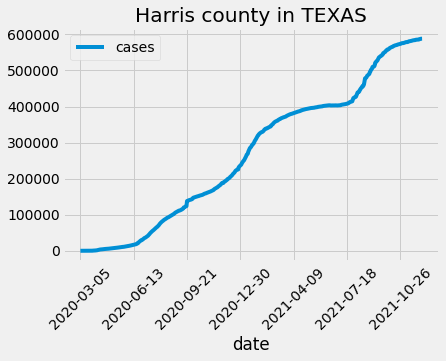

In [ ]:
def plot_county(countyfip='48201', count='cases', count_type='raw'): 
  """
  This function plots the given county's covid cases or deaths history.
  Input: A string representing the county's fips number
         count is either cases or deaths
         count_type is either raw or per 1000
  Output: Plotting of one months of data for cases or deaths, either raw count or per 1000
  """
  # create small df and calculate cases and deaths per 1000
  covid_temp = covid.loc[(covid['fips']==countyfip)] # & (covid['date'].str.contains(year+'-'+month))]
  population = county_svi.loc[county_svi['FIPS']==countyfip, 'population'].values
  # find the state and county name to put in plot title
  state = county_svi.loc[county_svi['FIPS']==countyfip, 'STATE'].values
  county = county_svi.loc[county_svi['FIPS']==countyfip, 'COUNTY'].values
  title = county+' county in '+state
  # calculate cases and deaths per 1000
  covid_temp['cases per 1000'] = covid_temp['cases'] / population * 1000
  covid_temp['deaths per 1000'] = covid_temp['deaths'] / population * 1000

  # plot
  if ((count=='cases') & (count_type=='raw')):
    covid_temp.plot(x='date', y='cases', rot=45)
    plt.title(*title);
  elif ((count=='cases') & (count_type=='per 1000')):   
    covid_temp.plot(x='date', y='cases per 1000', rot=45)
    plt.title(*title);
  elif ((count=='deaths') & (count_type=='raw')):   
    covid_temp.plot(x='date', y='deaths', rot=45)
    plt.title(*title);
  elif ((count=='deaths') & (count_type=='per 1000')):   
    covid_temp.plot(x='date', y='deaths per 1000', rot=45)
    plt.title(*title);
  else:
    print('Please input correct parameters!')

# Test
plot_county(countyfip='48201', count='cases', count_type='raw')

Compare counties with the lowest mask score (left) vs. the highest  mask score (right)


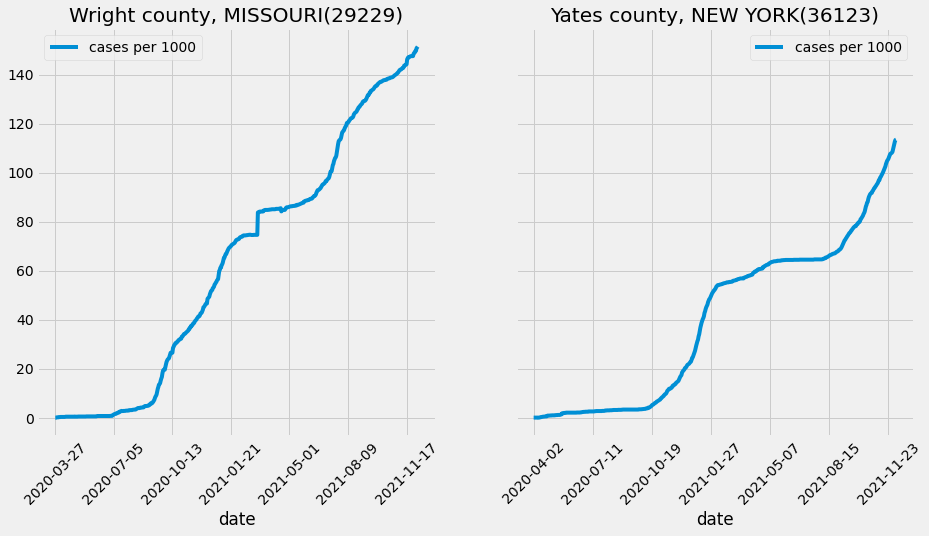

In [ ]:
def plot_county_compare(compare='mask score', count='cases'): 
  """
  This function plots two counties to compare based one feature.
  Input: A string representing the column name in county_svi dataframe
         count is either cases or deaths
  Output: two plots to compare
  """

  compare_df = county_svi_covid.sort_values(by=compare)
  low_fip = compare_df.head(1)['FIPS'].values[0]

  covid_temp_low = covid.loc[(covid['fips']==low_fip)]
  population_low = county_svi.loc[county_svi['FIPS']==low_fip, 'population'].values
  state_low = county_svi.loc[county_svi['FIPS']==low_fip, 'STATE'].values
  county_low = county_svi.loc[county_svi['FIPS']==low_fip, 'COUNTY'].values
  title_low = county_low + ' county, '+state_low + '(' + low_fip + ')'
  covid_temp_low['cases per 1000'] = covid_temp_low['cases'] / population_low * 1000
  covid_temp_low['deaths per 1000'] = covid_temp_low['deaths'] / population_low * 1000

  high_fip = compare_df.tail(1)['FIPS'].values[0]
  covid_temp_high = covid.loc[ (covid['fips']==high_fip)]
  population_high = county_svi.loc[county_svi['FIPS']==high_fip, 'population'].values
  state_high = county_svi.loc[county_svi['FIPS']==high_fip, 'STATE'].values
  county_high = county_svi.loc[county_svi['FIPS']==high_fip, 'COUNTY'].values
  title_high = county_high + ' county, ' + state_high + '(' + high_fip + ')'
  covid_temp_high['cases per 1000'] = covid_temp_high['cases'] / population_low * 1000
  covid_temp_high['deaths per 1000'] = covid_temp_high['deaths'] / population_low * 1000

  print('Compare counties with the lowest '+compare+' (left) vs. the highest  '+compare+' (right)')

  if (count=='cases'):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 7))
    covid_temp_low.plot(x='date', y='cases per 1000', rot=45, ax=axes[0], subplots=True, title=title_low)
    covid_temp_high.plot(x='date', y='cases per 1000', rot=45, ax=axes[1], subplots=True, title=title_high);
  elif (count=='deaths'): 
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
    covid_temp_low.plot(x='date', y='deaths per 1000', rot=45, ax=axes[0], subplots=True, title=title_low)
    covid_temp_high.plot(x='date', y='deaths per 1000', rot=45, ax=axes[1], subplots=True, title=title_high);
  else:
    print('Please input correct parameters!')

# Test the function for mask score
plot_county_compare(compare='mask score', count='cases')

Compare counties with the lowest population density (left) vs. the highest  population density (right)


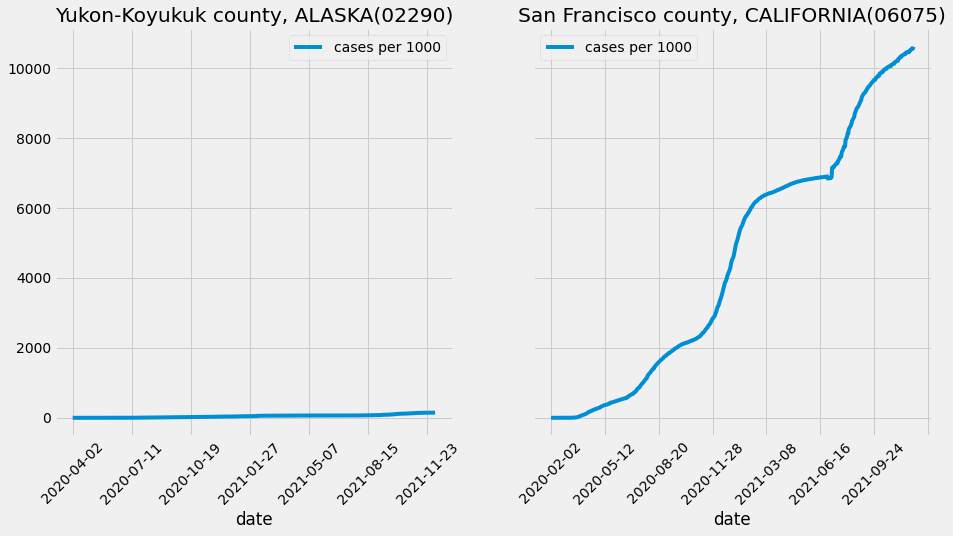

In [ ]:
# Test the function for population density
plot_county_compare(compare='population density', count='cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


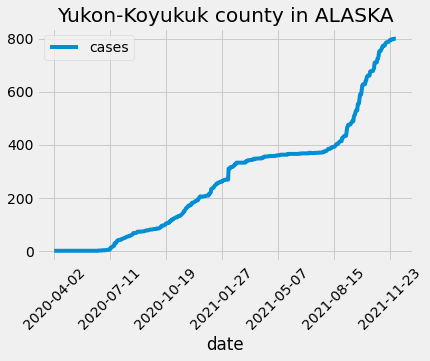

In [ ]:
# Test out the function for Yukon-Koyukuk County
plot_county(countyfip='02290', count='cases', count_type='raw')

# Exploratory Data Analysis #

## Univariate Analysis

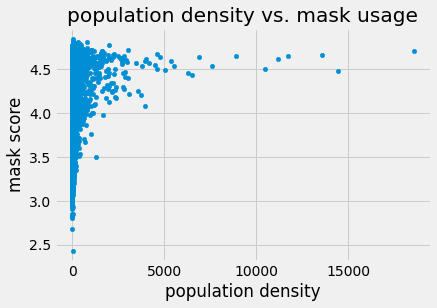

In [ ]:
# Plot Population Density vs. Mask Usage

county_svi_covid.plot(kind='scatter', x='population density', y='mask score').set(title='population density vs. mask usage');

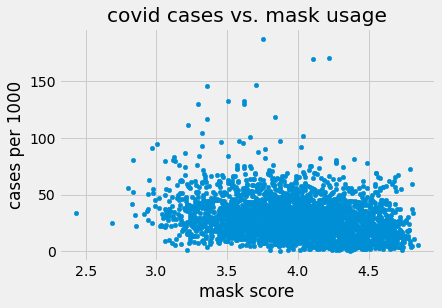

In [ ]:
# Plot Mask Usage vs. Cases per 1000

county_svi_covid.plot(kind='scatter', x='mask score', y='cases per 1000').set(title='covid cases vs. mask usage');

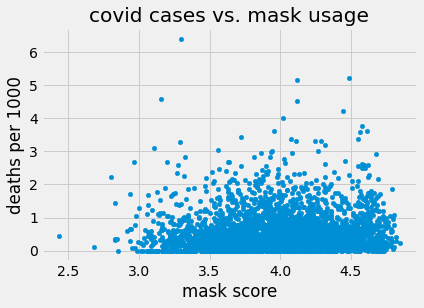

In [ ]:
# Plot Mask Usage vs. Covid Deaths per 1000

county_svi_covid.plot(kind='scatter', x='mask score', y='deaths per 1000').set(title='covid cases vs. mask usage');

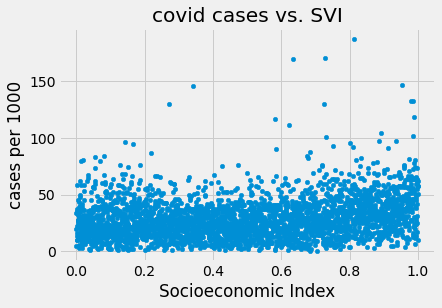

In [ ]:
# Plot Socioeconomic Index vs. Covid Cases per 1000

county_svi_covid.plot(kind='scatter', x='Socioeconomic Index', y='cases per 1000').set(title='covid cases vs. SVI');

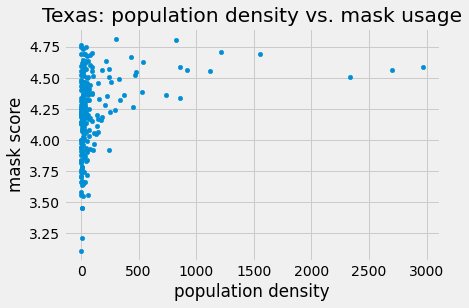

In [ ]:
# in Texas?
Texas = county_svi_covid[county_svi_covid['STATE']=='TEXAS']
Texas.plot(kind='scatter', x='population density', y='mask score').set(title='Texas: population density vs. mask usage');

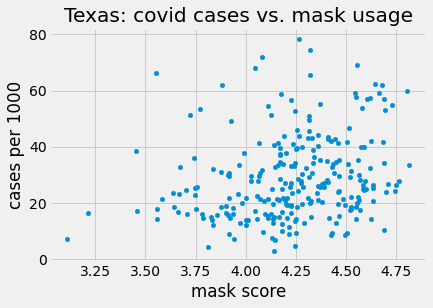

In [ ]:
Texas.plot(kind='scatter', x='mask score', y='cases per 1000').set(title='Texas: covid cases vs. mask usage');

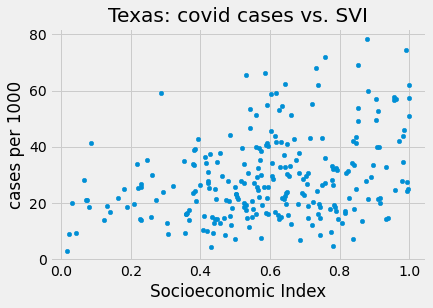

In [ ]:
Texas.plot(kind='scatter', x='Socioeconomic Index', y='cases per 1000').set(title='Texas: covid cases vs. SVI');

### 7-day moving average

In [ ]:
texas_covid_may_to_july = pd.read_csv('/content/drive/Shareddrives/DSCI101Fa21Team4/texas_covid_may_to_july.csv')
county_infections_and_mask = pd.read_csv('/content/drive/Shareddrives/DSCI101Fa21Team4/county_infections_and_mask.csv')

texas_covid_may_to_july = texas_covid_may_to_july.iloc[: , 1:]
county_infections_and_mask = county_infections_and_mask.iloc[: , 1:]

In [ ]:
# Functions that will used to plot the 7-day moving average of new cases for each counties. Because the population for all counties are different, 
# the new cases will be calculated as an average cases, which is new cases devided by the county's population.

def seven_days_moving_average_multiple(countyfp_list, df):
  """
  This function saves a multiple counties' 7-day moving average of new cases data to a given dataframe
  Input: A list of integer numbers representing the counties' fips numbers. An empty dataframe that will save the moving average data
  """
  for county in countyfp_list:
    temp_infections = texas_covid_may_to_july.loc[texas_covid_may_to_july['county'] == county]
    population = county_infections_and_mask.loc[county_infections_and_mask['county'] == county]
    temp_infections['avg_cases'] = (temp_infections['cases'] / county_infections_and_mask.loc[county_infections_and_mask['county'] == county].iloc[0,4]) * 1000
    temp_infections = temp_infections.reset_index(drop=True)
    df[str(county) + ' MA 7days'] = temp_infections['avg_cases'].rolling(7).mean()

### 1. Analyzing the relationship between mask uasge and Covid cases

In [ ]:
#Sort counties by highest to lowest Mask Score
county_infections_and_mask.sort_values(by='mask score', ascending=False)

,county,state,countyfp,mask score,population,pop_density,socioeconomic,age&disability,minority_stat,housing_type
103,Hays,Texas,48209,4.815,213366,356.16,0.1660,0.0237,0.5771,0.5257
68,El Paso,Texas,48141,4.805,836062,854.35,0.8854,0.6640,0.9644,0.8103
113,Hudspeth,Texas,48229,4.763,4415,0.7,0.9723,0.7945,0.9723,0.7866
6,Atascosa,Texas,48013,4.751,49528,40.16,0.7708,0.6008,0.7233,0.7708
185,Presidio,Texas,48377,4.746,6975,1.59,0.9881,0.9723,0.9802,0.8063
...,...,...,...,...,...,...,...,...,...,...
204,Scurry,Texas,48415,3.553,17096,18.7,0.4743,0.2055,0.4941,0.6206
36,Childress,Texas,48075,3.456,7253,9.57,0.7589,0.0830,0.3834,0.7075
104,Hemphill,Texas,48211,3.453,3994,3.73,0.3953,0.6917,0.6759,0.6166
237,Wheeler,Texas,48483,3.216,5338,5.46,0.4466,0.8577,0.5020,0.1858


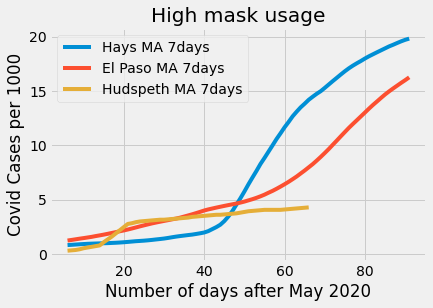

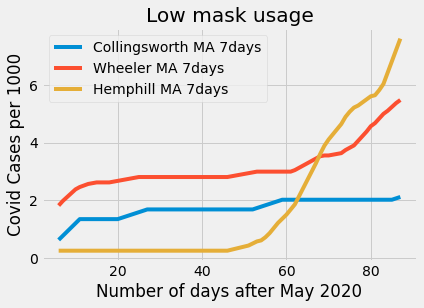

In [ ]:
# Relationship between mask usage and covid cases 
good_mask_score = pd.DataFrame()
bad_mask_score = pd.DataFrame()

good_mask_counties = ['Hays', 'El Paso', 'Hudspeth']
bad_mask_counties = ['Collingsworth', 'Wheeler', 'Hemphill']

seven_days_moving_average_multiple(good_mask_counties, good_mask_score)
seven_days_moving_average_multiple(bad_mask_counties, bad_mask_score)

good_mask_score.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per 1000', title='High mask usage')
bad_mask_score.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per 1000', title='Low mask usage')
plt.legend();

### 2. Analyzing the relationship between population density and Covid cases

In [ ]:
#Sort counties by highest to lowest population density
county_infections_and_mask.sort_values(by='pop_density', ascending=False)

,county,state,countyfp,mask score,population,pop_density,socioeconomic,age&disability,minority_stat,housing_type
201,San Patricio,Texas,48409,4.700,67008,99.15,0.5850,0.8221,0.7154,0.6798
231,Walker,Texas,48471,4.373,72321,97.42,0.6759,0.0000,0.4980,0.9328
77,Fort Bend,Texas,48157,4.585,765394,954.81,0.0593,0.0870,0.7905,0.1067
3,Aransas,Texas,48007,4.552,24462,94.54,0.5178,0.5534,0.3281,0.7945
105,Henderson,Texas,48213,4.156,81070,94.02,0.5455,0.4427,0.1581,0.5652
...,...,...,...,...,...,...,...,...,...,...
67,Edwards,Texas,48137,4.404,1918,0.67,0.2174,0.4980,0.6561,0.0909
53,Culberson,Texas,48109,4.228,2214,0.57,0.9447,0.9605,0.8775,0.9130
158,McMullen,Texas,48311,4.199,774,0.53,0.2806,0.9644,0.5731,0.3636
217,Terrell,Texas,48443,4.245,896,0.32,0.7431,0.1542,0.7589,0.0277


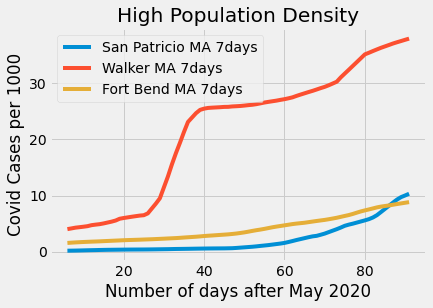

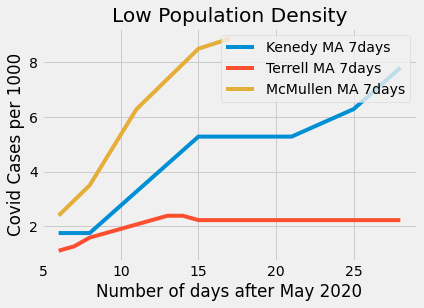

In [ ]:
# Relationship between population density and covid cases 
high_pop_density = pd.DataFrame()
low_pop_density = pd.DataFrame()

high_density_counties = ['San Patricio', 'Walker', 'Fort Bend']
low_density_counties = ['Kenedy', 'Terrell', 'McMullen']

seven_days_moving_average_multiple(high_density_counties, high_pop_density)
seven_days_moving_average_multiple(low_density_counties, low_pop_density)

high_pop_density.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per 1000', title='High Population Density')
low_pop_density.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per 1000', title='Low Population Density')
plt.legend();

### 3. Analyzing relationship between socioeconomic and Covid cases

In [ ]:
#Sort counties by highest to lowest population density
county_infections_and_mask.sort_values(by='socioeconomic', ascending=False)

,county,state,countyfp,mask score,population,pop_density,socioeconomic,age&disability,minority_stat,housing_type
210,Starr,Texas,48427,4.679,64078,53.89,1.0000,0.9130,1.0000,0.5889
240,Willacy,Texas,48489,4.621,21588,34.14,0.9960,0.7233,0.9526,0.8419
248,Zapata,Texas,48505,4.601,14304,13.91,0.9921,0.9565,0.9881,0.8577
185,Presidio,Texas,48377,4.746,6975,1.59,0.9881,0.9723,0.9802,0.8063
155,Maverick,Texas,48323,4.319,58174,45.24,0.9842,0.8379,0.9960,0.6403
...,...,...,...,...,...,...,...,...,...,...
187,Randall,Texas,48381,4.067,134026,154.21,0.0198,0.0909,0.1700,0.1937
128,Kendall,Texas,48259,4.505,43769,66.84,0.0158,0.2490,0.2174,0.1186
5,Armstrong,Texas,48011,4.000,1973,2.03,0.0119,0.1146,0.0356,0.1146
41,Collin,Texas,48085,4.554,973977,"1,265.32",0.0079,0.0395,0.5613,0.0711


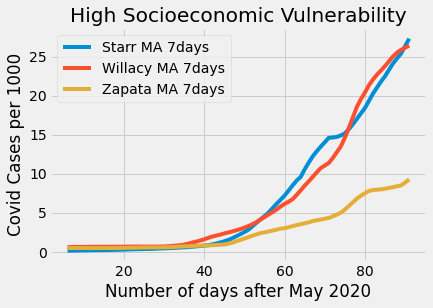

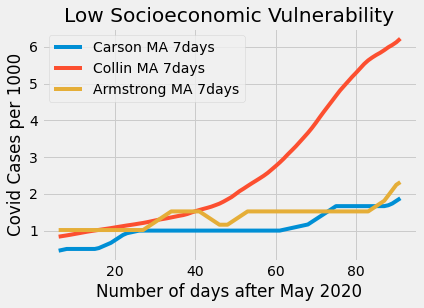

In [ ]:
# Relationship between socioeconomics and covid cases 
high_socio_score = pd.DataFrame()
low_socio_score = pd.DataFrame()

high_socio_counties = ['Starr', 'Willacy', 'Zapata']
low_socio_counties = ['Carson', 'Collin', 'Armstrong']

seven_days_moving_average_multiple(high_socio_counties, high_socio_score)
seven_days_moving_average_multiple(low_socio_counties, low_socio_score)

high_socio_score.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per 1000', title='High Socioeconomic Vulnerability')
low_socio_score.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per 1000', title='Low Socioeconomic Vulnerability')
plt.legend();

### 4. Analyzing the relationship between Household Composition & Disability and Covid cases

In [ ]:
#Sort counties by highest to lowest age and disability value
county_infections_and_mask.sort_values(by='age&disability', ascending=False)

,county,state,countyfp,mask score,population,pop_density,socioeconomic,age&disability,minority_stat,housing_type
49,Cottle,Texas,48101,3.702,1642,1.53,0.9368,1.0000,0.3755,0.0949
169,Motley,Texas,48345,4.204,1252,1.07,0.3360,0.9960,0.1107,0.1462
122,Jim Hogg,Texas,48247,4.450,5231,4.26,0.9565,0.9921,0.8577,0.4427
62,Dimmit,Texas,48127,4.412,10438,6.48,0.9684,0.9881,0.9012,0.9526
64,Duval,Texas,48131,4.191,11268,5.48,0.9644,0.9842,0.8656,0.8735
...,...,...,...,...,...,...,...,...,...,...
191,Reeves,Texas,48389,4.224,15492,5.6,0.8103,0.0158,0.9565,0.8538
222,Travis,Texas,48453,4.710,1226805,"1,297.91",0.0711,0.0079,0.7391,0.6087
46,Concho,Texas,48095,4.437,3266,3.36,0.5217,0.0079,0.8814,0.5850
85,Glasscock,Texas,48173,4.217,1510,1.24,0.1462,0.0040,0.7866,0.0316


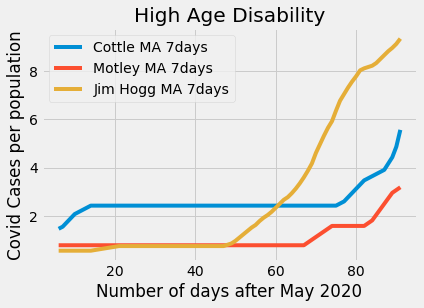

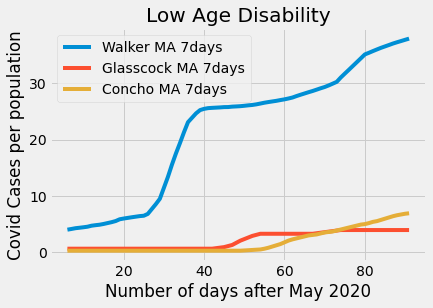

In [ ]:
high_age_disability = pd.DataFrame()
low_age_disability = pd.DataFrame()

high_age_disability_counties = ["Cottle", "Motley", "Jim Hogg"]
low_age_disability_counties = ["Walker", "Glasscock", "Concho"]

seven_days_moving_average_multiple(high_age_disability_counties, high_age_disability)
seven_days_moving_average_multiple(low_age_disability_counties, low_age_disability)

high_age_disability.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per population', title='High Age Disability')
low_age_disability.plot().set(xlabel='Number of days after May 2020', ylabel='Covid Cases per population', title='Low Age Disability')
plt.legend();

# Conclusion for 7 day moving average data visulaization
## Relationship between mask usage and covid cases
The upper graph shows the covid cases per population with good mask usage and the lower graph shows the covid cases per population with bad mask usage.

Before analyzing the data, we inferred that the good mask usage will result in lower covid cases. However, when we compared the graphs, there’s no big difference between good and bad mask usage. Thus, we concluded that the mask usage is not related to the number of covid cases per population.

## Relationship between population density and covid cases
The upper graph shows higher population density and the lower graph shows lower population density.

Before analyzing the data, we inferred that the higher population density will result in higher covid cases. By comparing two graphs, we can see that the higher population density resulted in higher covid cases, so we concluded that there is a direct relationship between population density and covid cases.

## Relationship between the socioeconomics and covid cases
The upper graph shows higher vulnerability and the lower graph shows lower vulnerability.

Before analyzing the data, we inferred that the higher vulnerability will result in higher covid cases. When we compare the graphs, the higher graph (higher vulnerability) shows higher covid cases. Thus, we concluded that social vulnerability does correlate to the number of covid cases.

## Relationship between age disability and covid cases
There are no big difference between two graphs. Also, county fips number 48471 acted as an outlier.

Therefore, population density and socioeconomic vulnerability seems to have relationship with number of covid cases.

# Hypothesis Testing #

We conducted Hypothesis Testing to determine whether there exists a correlation between the Population Density and Number of Covid Cases per 1000 people in each county.

We picked the the significance level alpha to be 5%.

Our hypotheses are:

**Null Hypothesis**: There does not exist a statistically significant correlation between population density and number of Covid cases by county.

**Alternative Hypothesis**: There does exist a statistically significant correlation between population density and number of Covid cases by county.

Our measured **test statistic** was the **correlation coefficient** between Population Density and Number of Covid Cases.

The **observed statistic takes** the correlation coefficient between county population density and *observed* covid case numbers data.

A **simulated statistic** takes the correlation coefficient between the county population density and *randomly generated* covid case numbers data.

We randomly generated covid case numbers data for each county by randomly shuffling the covid case numbers data column while fixing the population density data column.

In [ ]:
# We first took out columns of interest: population density and covid cases
pop_den_vs_covid = county_svi_covid[['population density','cases']]
pop_den_vs_covid

,population density,cases
0,6.706684,543
1,92.859967,2173
2,89.395591,2095
3,25.777569,1024
4,189.972308,4892
...,...,...
3125,6.331280,499
3126,14.391855,358
3127,9.350192,558
3128,8.024026,294


In [ ]:
# Find the observed statistic by taking the correlation coefficient between the given population density and covid case numbers data
pop_den_vs_covid_observed_corr = pop_den_vs_covid.corr()
observed_stat = pop_den_vs_covid_observed_corr.iloc[0,1]
observed_stat

0.35795362362336797

In [ ]:
#Find one simulated statistic by taking the correlation coefficient between the current population density and randomly shuffled covid case numbers data

#create a new dataframe with randomly shuffled covid cases among all the counties
pop_den_vs_covid_shuffled = pop_den_vs_covid
pop_den_vs_covid_shuffled['cases'] = np.random.permutation(pop_den_vs_covid_shuffled['cases'].values)

#find the new correlation coefficient
pop_den_vs_covid_simu_corr = pop_den_vs_covid_shuffled.corr()
one_simu_stat = pop_den_vs_covid_simu_corr.iloc[0,1]
one_simu_stat

-0.012889079838556713

We wrote a function that takes as its input the names of 2 variables (i.e. any 2 variable column names in the covid dataframe) and the significance level alpha (default alpha = 5%), and randomly generates a list of 1000 simulated statistics by repeated random shuffling the *dependent* variable data while fixing the *independent* variable data and finding the new correlation coefficient after each shuffle.

We performed a *one-sided* test with the *positive* direction of the test statistic favoring the alternative hypothesis because we are testing to see if there is a strong a positive correlation between Population Density and Covid case numbers. The p-value should be the right-hand tail area.

We calculated the 95th percentile cutoff of our data to test whether our observed statistic demonstrates a statistically significant correlation, since we set our significance level to be 5%. We then visualized the simulated data into a histogram, and plotted the cutoff line and observed statistic.

We wrote this as a function so we can later pass different variables and use the same code more efficiently for implementing future data when examining factors that affect Covid case numbers by county.

We then applied this function below to pass Population Density as the independent variable input and Number of Covid Cases as the dependent variable input so that it returns a list of 10000 simulated statistics to find data relevant to our above hypothesis.

0.0

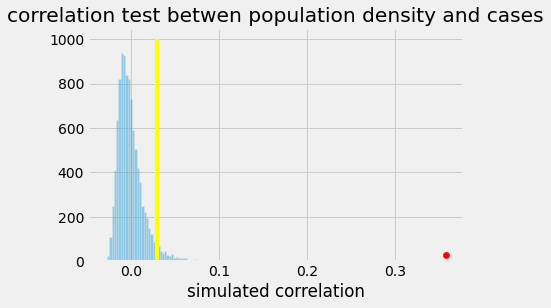

In [ ]:
#Write a function with input String variable name that randomly generates a list simulated statistics
def simulate_stats(independent, dependent, alpha=0.05):
  #creates a new dataframe by taking out "independent" and "dependent" columns
  data = county_svi_covid[[independent,dependent]]

  #finds the observed statistic by taking the correlation coeff of the observed data
  data_observed_corr = data.corr()
  observed_stat = data_observed_corr.iloc[0,1]

  #initialize empty list to store the simulated statistics
  simu_stats = []
  #generate 10000 simulated statistics
  rep = 10000
  for i in np.arange(rep):
      #create a new dataframe with randomly shuffled covid cases among all the counties
      data_shuffled = data
      data_shuffled[dependent] = np.random.permutation(data_shuffled[dependent].values)
      #find the new correlation coefficient
      data_simu_corr = data_shuffled.corr()
      one_simulated_stat = data_simu_corr.iloc[0,1]
      #add it to the list of simulated statistics
      simu_stats = np.append(simu_stats, one_simulated_stat)
      
  #calculate upper percentile cutoff
  percentile = 100*(1-alpha)
  cut_off = np.percentile(simu_stats, percentile)

  #calculate the p-value
  p_value = np.average(simu_stats >= observed_stat)

  #visualize the simulated statistics list as a histogram
  visualization = plt.hist(simu_stats, bins=100, alpha=0.4)
  #visualize the observed statistic as a red point
  visualization = plt.scatter(observed_stat, 30, color='red', s=40)
  #visualize the cutoff point as a yellow line
  visualization = plt.plot([cut_off,cut_off],[0,1000], color='yellow')
  visualization = plt.xlabel('simulated correlation')
  visualization = plt.title('correlation test betwen '+ independent +' and ' + dependent);
  
  return p_value

#applies the function to our hypothesis variables Population Density and Number of Covid Cases
pop_den_p_value = simulate_stats('population density', 'cases')
pop_den_p_value

**Conclusion**: Since the observed statistic is greater than the 95% cutoff point and the p-value=0 is less than the established significance level of alpha=0.05, we **reject the null hypothesis** and conclude that there does exist a statistically significant correlation between population density and number of Covid cases by county.

## Bivariate Analysis ##
The relationships between population density, mask score, per capita income", unemployment, age 65 above, covid cases per 1000, covid deaths per 1000 were all compared to one another using bi-variate scatter plots.

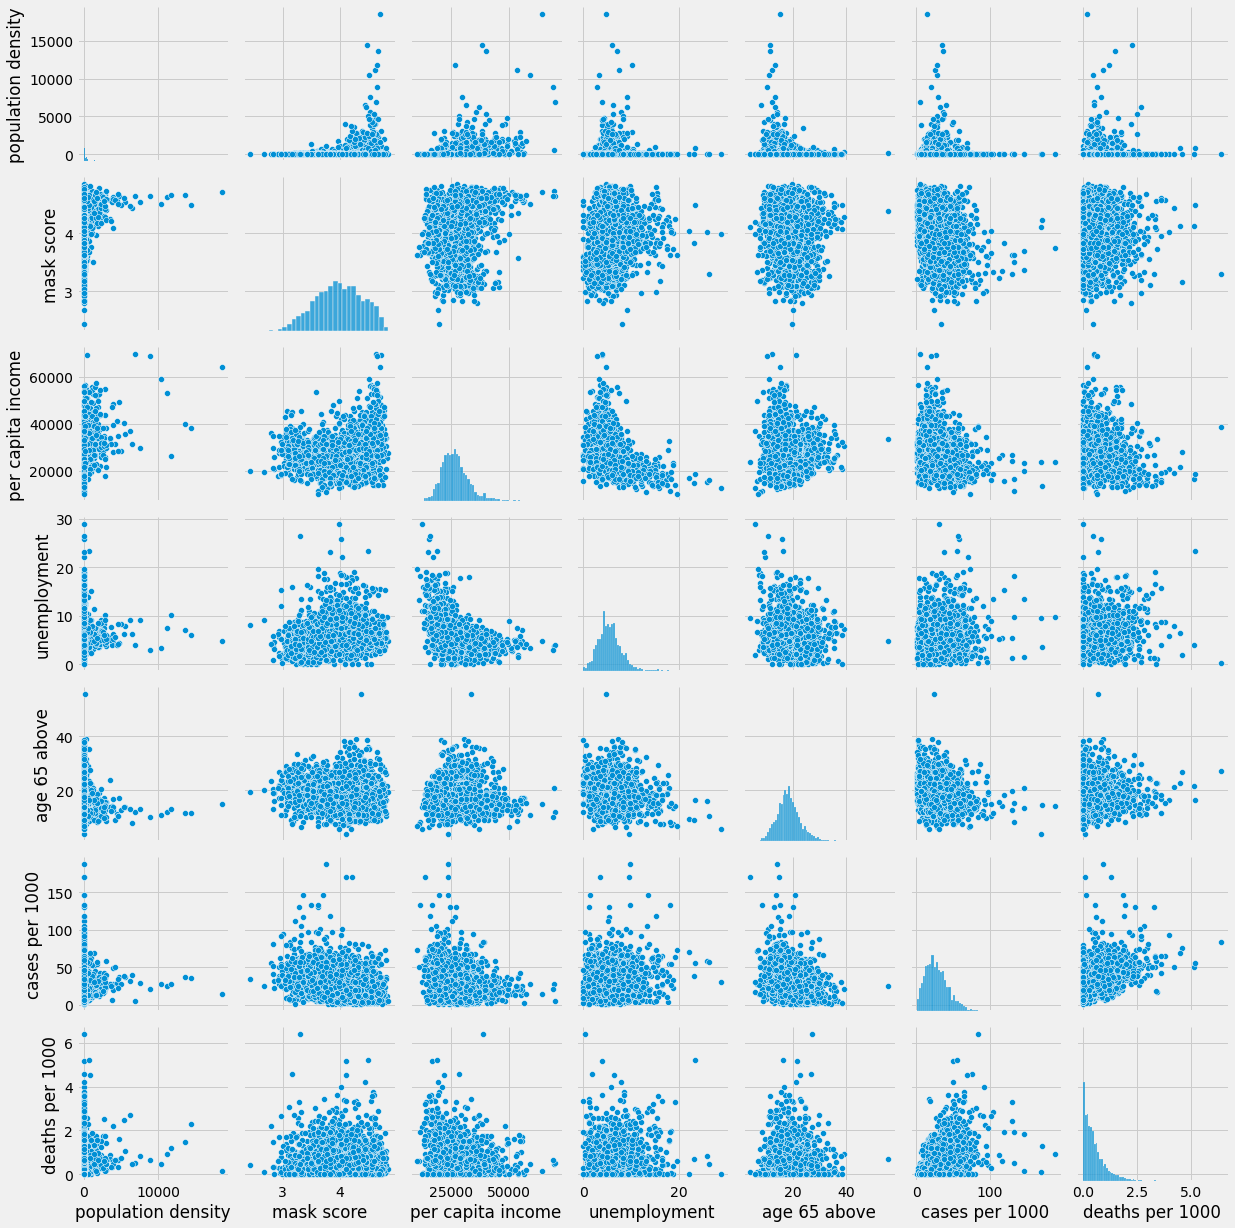

In [ ]:
# Select a list of numerical columns
num_cols = ["population density", "mask score", "per capita income", "unemployment", "age 65 above", "cases per 1000", "deaths per 1000"]
select_df = county_svi_covid[num_cols]
# Visualize in a scatter plot matrix
sns.pairplot(select_df)

Because the data is very crowded, it is difficult to observe clear trends in the scatterplot. However, we do still observe: 


*   a slight negative correlation between Population Density and Covid Cases per 1000
*   a slight negative correlation between Population Density and Covid Deaths per 1000
*   a slight negative correlation between Mask Score and Covid Cases per 1000
*   no noticeable correlation between Mask Score and Covid Deaths per 1000
*   a moderate negative correlation between Per Capita Income and Covid Cases per 1000
*   a moderate negative correlation between Per Capita Income and Covid Deaths per 1000
*   a moderate positive correlation between Unemployment and Covid Cases per 1000
*   a slight positive correlation between Unemployment and Covid Deaths per 1000
*   a slight negative correlation between Age 65 Above and Covid Cases per 1000
*   a moderate positive correlation between Age 65 Above and Covid Deaths per 1000

The plots on the diagonals are not scatter plots because they include the same variable on both the x and y axes. Thus, they do not display the correlation between two different variables.

Can you see an application of supervised learning model using your data? In other words, can you predict one of the variable (response) in your dataset using one or more variables (features). 

We can try to predict Covid Cases by 1000 (response variable) using Population Density (feature variable) or Per Capita Income (feature variable) for each county.

Is your supervised learning problem a regression or classification? In other words, is your response variable a numerical variable or categorical variable? Sometimes you can also create a categorical variable based on a numerical one: for example put age into age groups.

Our supervised learning problem is a regression because our response variables are numerical.

## Principal Component Analysis (PCA) ##

Since our data has too many numerical variables, we visulized it by doing dimension reduction using PCA, and plot the first 2 principal components on a scatter plot.

In [ ]:
# Select all the numerical variables
county_svi_covid2 = pd.read_csv('/content/drive/Shareddrives/DSCI101Fa21Team4/county_svi_covid.csv')

all_num_cols = ["population density", "mask score", "per capita income", "unemployment", "age 65 above", "covid cases per 1000", "covid deaths per 1000"]
num_df = county_svi_covid2[all_num_cols]
num_df

,population density,mask score,per capita income,unemployment,age 65 above,covid cases per 1000,covid deaths per 1000
0,92.859967,4.003,29372.0,4.2,14.6,185.833333,2.681159
1,89.395591,3.892,22656.0,4.1,17.8,180.553387,3.087865
2,25.777569,3.782,20430.0,6.7,19.0,167.440699,4.794007
3,189.972308,3.636,24706.0,8.8,16.8,194.182349,4.300683
4,56.701696,3.985,22827.0,5.0,18.9,171.051854,4.227517
...,...,...,...,...,...,...,...
3127,6.331280,4.191,17864.0,10.6,17.8,171.730515,5.107882
3128,14.391855,4.601,17228.0,11.0,13.9,153.594544,3.131742
3129,9.350192,4.258,13350.0,8.4,13.7,207.814690,4.451405
3130,8.024026,4.412,18121.0,16.4,16.3,354.778205,4.220201


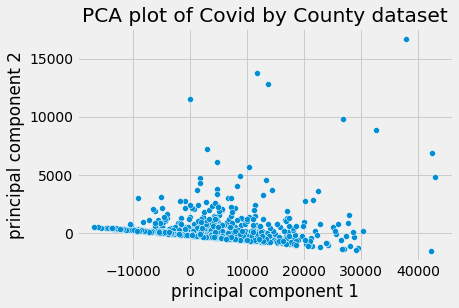

In [ ]:
# Make a scatter plot of 1st and 2nd PC of the data

from sklearn.decomposition import PCA
pca = PCA(n_components=3) 
your_pca = pca.fit_transform(num_df)

sns.scatterplot(x=your_pca[:,0], y=your_pca[:,1])
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.title('PCA plot of Covid by County dataset');

In [ ]:
# Examine outliers on the right side
county_svi_covid2[your_pca[:,0] > 30000]

,Unnamed: 0,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,area,population,below poverty,unemployment,per capita income,no high school diploma,age 65 above,disabled,single parent,minority,no vehicle,Socioeconomic Index,Household Composition Index,Minority Index,Housing Transportation Index,cases,deaths,never,rarely,sometimes,frequently,always,population density,covid cases per 1000,covid deaths per 1000,mask score
1366,1367,CALIFORNIA,CA,Marin,6041,"Marin County, California",520.456534,260295.0,7.6,3.8,69275.0,6.8,21.0,8.9,6.2,28.6,4.9,0.0334,0.0751,0.8415,0.6985,17890.0,247.0,0.011,0.000,0.046,0.141,0.802,500.128220,68.729711,0.948923,4.723
2075,2076,VIRGINIA,VA,Falls Church City,51610,"Falls Church city, Virginia",2.046443,14067.0,2.7,3.9,69775.0,1.2,12.1,5.9,7.7,28.3,4.6,0.0089,0.1102,0.6581,0.3464,563.0,12.0,0.007,0.033,0.038,0.158,0.765,6873.878572,40.022748,0.853060,4.644
2430,2431,VIRGINIA,VA,Arlington,51013,"Arlington County, Virginia",25.997406,231803.0,7.2,2.9,69051.0,5.9,10.1,5.9,4.2,38.2,12.6,0.0092,0.0000,0.8809,0.7765,18674.0,271.0,0.010,0.018,0.035,0.187,0.750,8916.389581,80.559786,1.169096,4.649
2440,2441,VIRGINIA,VA,Alexandria City,51510,"Alexandria city, Virginia",14.933151,156505.0,10.6,3.3,59239.0,7.5,10.8,7.0,6.0,48.2,9.2,0.0685,0.0025,0.9408,0.7192,14331.0,149.0,0.032,0.020,0.065,0.170,0.712,10480.373640,91.568959,0.952046,4.507
2714,2719,CALIFORNIA,CA,San Mateo,6081,"San Mateo County, California",448.635325,765935.0,7.0,4.1,57375.0,10.8,15.4,8.5,5.7,60.4,5.4,0.1185,0.0201,0.9682,0.6043,54780.0,625.0,0.016,0.013,0.058,0.126,0.786,1707.255219,71.520429,0.815996,4.650
2845,2851,CALIFORNIA,CA,San Francisco,6075,"San Francisco County, California",46.863393,870044.0,10.9,4.7,64157.0,11.5,15.1,10.3,3.8,59.4,30.6,0.2239,0.0035,0.9742,0.9497,55024.0,661.0,0.017,0.011,0.035,0.121,0.817,18565.535711,63.242779,0.759732,4.713


In [ ]:
# Examine outliers on the top
county_svi_covid2[your_pca[:,1] > 10000]

,Unnamed: 0,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,area,population,below poverty,unemployment,per capita income,no high school diploma,age 65 above,disabled,single parent,minority,no vehicle,Socioeconomic Index,Household Composition Index,Minority Index,Housing Transportation Index,cases,deaths,never,rarely,sometimes,frequently,always,population density,covid cases per 1000,covid deaths per 1000,mask score
2762,2767,MASSACHUSETTS,MA,Suffolk,25025,"Suffolk County, Massachusetts",58.245457,791766.0,19.3,7.0,40190.0,14.5,11.5,12.3,9.7,55.0,32.4,0.5608,0.0474,0.9656,0.9774,108069.0,1920.0,0.020,0.007,0.049,0.136,0.788,13593.609541,136.491084,2.424959,4.665
2845,2851,CALIFORNIA,CA,San Francisco,6075,"San Francisco County, California",46.863393,870044.0,10.9,4.7,64157.0,11.5,15.1,10.3,3.8,59.4,30.6,0.2239,0.0035,0.9742,0.9497,55024.0,661.0,0.017,0.011,0.035,0.121,0.817,18565.535711,63.242779,0.759732,4.713
2883,2889,NEW JERSEY,NJ,Hudson,34017,"Hudson County, New Jersey",46.190219,668631.0,16.3,6.1,38147.0,15.8,11.5,9.2,10.2,71.1,32.2,0.4943,0.0627,0.9914,0.8434,97624.0,2390.0,0.022,0.019,0.077,0.211,0.670,14475.597002,146.005794,3.574468,4.485
3056,3065,PENNSYLVANIA,PA,Philadelphia,42101,"Philadelphia County, Pennsylvania",134.232750,1575522.0,24.9,10.2,26557.0,16.1,13.2,16.3,12.5,65.4,30.3,0.8153,0.5549,0.9675,0.8949,182323.0,4018.0,0.023,0.012,0.051,0.120,0.794,11737.239954,115.722281,2.550266,4.650


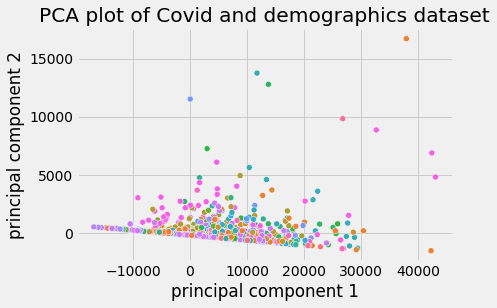

In [ ]:
# Color code the scatter plot using State as a categorical variable

cat_col = 'STATE'
sns.scatterplot(x=your_pca[:,0], y=your_pca[:,1], 
                hue=county_svi_covid2[cat_col], legend=False)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.title('PCA plot of Covid and demographics dataset');

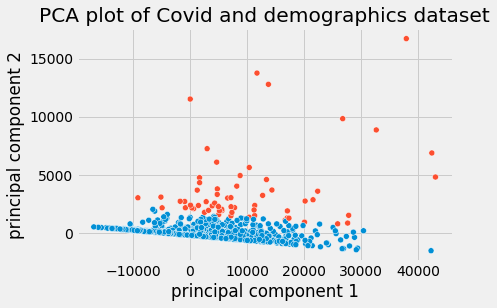

In [ ]:
# The PC 2 looks like it is mostly population density
high_pop_den = county_svi_covid2['population density'] >=2000
sns.scatterplot(x=your_pca[:,0], y=your_pca[:,1], 
                hue=high_pop_den, legend=False)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.title('PCA plot of Covid and demographics dataset');

### Shape the data for modeling

We seperated the feature matrix and response variable, and split the data into training set and testing set.

In [ ]:
county_svi_covid = county_svi_covid2

# Set mask score as the regression feature, 
# and covid cases per 1000 as the response variable

reg_feature = 'mask score'
response = 'covid cases per 1000'

# Take out the regression feature column and response variable column
X = county_svi_covid[[reg_feature]]
y = county_svi_covid[response]

# Split data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021)

### KNN regression ###

We picked the hyperparameter of the KNN model to be 10 and used the training and testing data to make predictions on the county Covid case numbers.

The error measure we used is Root Mean Square Error (RMSE). There is a build-in function to calculate mean square error (MES), so we take the square root of MSE.

In [ ]:
from sklearn import neighbors
# n_neighbors is the hyperparameter of your knn model
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=1)
pop_den_knn_reg = knn_reg.fit(X_train, y_train)

# make prediction on both training and testing feature matrix
y_train_hat = pop_den_knn_reg.predict(X_train)
y_test_hat = pop_den_knn_reg.predict(X_test)

# calculate the root mean squared error on the training and testing data
from sklearn.metrics import mean_squared_error as mse
print("Training RMSE:", np.sqrt(mse(y_train, y_train_hat)))
print("Testing RMSE:", np.sqrt(mse(y_test, y_test_hat)))

Training RMSE: 33.13430771897528
Testing RMSE: 50.46352176961361


How does your model do? Remember the number of K you picked for your model? 

Now try out some other values of K and see how does that change your training and testing error. After a few trials, pick the best K that has the smallest testing error. The goal is just to try out this process, you do not have to find the ultimate "best" K here. 

Now we can visualize the performance of your KNN regression model. Fit your chosen KNN model to the entire dataset. 

In [ ]:
# We fit the KNN regression model to the regression feature and response data
K = 10
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=K)
your_knn_reg_final = knn_reg.fit(X, y)

step = (max(county_svi_covid[reg_feature]) - min(county_svi_covid[reg_feature]))/100
X_min = min(county_svi_covid[reg_feature]) - step
X_max = max(county_svi_covid[reg_feature]) + step

# make up some X values to predict
# we pretend this is the new X value which we do not know the corresponding y
# this is for visualization only
step = (max(county_svi_covid[reg_feature]) - min(county_svi_covid[reg_feature]))/100
X_min = min(county_svi_covid[reg_feature]) - step
X_max = max(county_svi_covid[reg_feature]) + step

# pick a step to create a sequence of feature X values
# this depends on the scale of X
X_plot = np.arange(X_min, X_max, step) 
# reshape into a feature matrix with one column 
X_plot = X_plot.reshape((len(X_plot), 1))
y_plot = your_knn_reg_final.predict(X_plot)

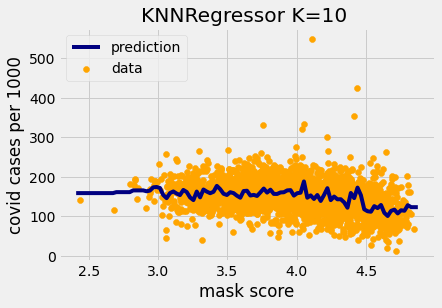

In [ ]:
# Plot the KNN regression model

plt.scatter(X, y, color='orange', label='data')
plt.plot(X_plot, y_plot, color='navy', label='prediction')
plt.axis('tight')
plt.xlabel(reg_feature)
plt.ylabel(response)
plt.legend()
plt.title('KNNRegressor K=%i '% K);

The observed prediction line seems around the average of the original data points. However, the data points are very varied, so it is still difficult to predict.

Because the data points are extremely varied where the bulk of the data points lie, the predicton curve would yield an inaccurate prediction, no matter what the K value is.

## Fit linear model with more features
Next, we selected more features to fit some linear models.

In [ ]:
# Drop select columns from the entire dataset
drop = ['STATE','FIPS','LOCATION','area','population','cases','deaths','never','rarely',
        'sometimes','frequently','always','covid deaths per 1000','COUNTY','Unnamed: 0', 'covid cases per 1000']
X_full = county_svi_covid.drop(columns=drop)
X_full_dummy = pd.get_dummies(X_full)

# New dataset with the response variable
y = county_svi_covid[response]

# Split the testing and training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full_dummy, y, test_size=0.25, random_state=2021)

### Linear regression ###

We created a least squares linear regression model and fit to the training data

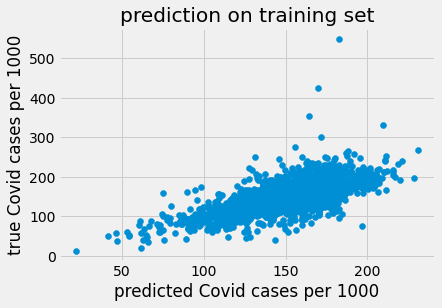

In [ ]:
# Create least squares linear regression model and fit to the training data

from sklearn.linear_model import LinearRegression
ls_model = LinearRegression(fit_intercept=True)
ls_model.fit(X_train, y_train)

# Use the model to predict on both training and testing
y_train_hat = ls_model.predict(X_train)
y_test_hat = ls_model.predict(X_test)

# Plot the predicted vs. true label on training
plt.scatter(x=y_train_hat, y=y_train)
plt.xlabel("predicted Covid cases per 1000")
plt.ylabel("true Covid cases per 1000")
plt.title("prediction on training set");

In [ ]:
# print out model coefficients, how to interpret them?
print(pd.Series(ls_model.coef_, index=X_full_dummy.columns))

below poverty             -0.759273
unemployment              -0.019099
per capita income         -0.001271
no high school diploma     0.752317
age 65 above              -1.780371
                            ...    
ST_ABBR_VT               -71.183871
ST_ABBR_WA               -25.029149
ST_ABBR_WI                12.765607
ST_ABBR_WV                 6.496511
ST_ABBR_WY                33.081856
Length: 66, dtype: float64


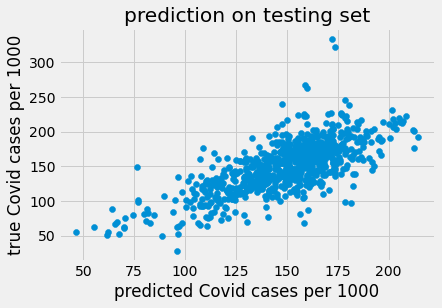

In [ ]:
# Plot the predicted vs. true label on testing
plt.scatter(x=y_test_hat, y=y_test)
plt.xlabel("predicted Covid cases per 1000")
plt.ylabel("true Covid cases per 1000")
plt.title("prediction on testing set");

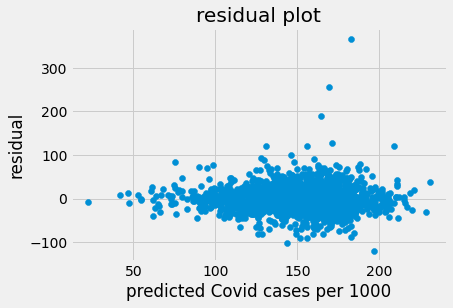

In [ ]:
# Plot the residuals plot
residual = y_train - y_train_hat
plt.scatter(x=y_train_hat, y=residual)
plt.xlabel("predicted Covid cases per 1000")
plt.ylabel("residual")
plt.title("residual plot");

In [ ]:
### Find the outliers
county_svi_covid.loc[X_train[residual > 100].index,:]

,Unnamed: 0,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,area,population,below poverty,unemployment,per capita income,no high school diploma,age 65 above,disabled,single parent,minority,no vehicle,Socioeconomic Index,Household Composition Index,Minority Index,Housing Transportation Index,cases,deaths,never,rarely,sometimes,frequently,always,population density,covid cases per 1000,covid deaths per 1000,mask score
3130,3140,TEXAS,TX,Dimmit,48127,"Dimmit County, Texas",1328.884075,10663.0,29.8,16.4,18121.0,32.7,16.3,23.0,13.0,90.5,11.9,0.9946,0.9936,0.9904,0.9316,3783.0,45.0,0.021,0.059,0.097,0.133,0.690,8.024026,354.778205,4.220201,4.412
2492,2495,COLORADO,CO,Bent,8011,"Bent County, Colorado",1512.846146,5809.0,22.9,7.2,14777.0,14.2,17.3,25.4,10.1,36.6,9.6,0.8701,0.6457,0.8313,0.8077,1742.0,27.0,0.033,0.036,0.172,0.191,0.567,3.839782,299.879497,4.647960,4.220
1365,1366,CALIFORNIA,CA,Lassen,6035,"Lassen County, California",4541.183303,31185.0,13.8,6.1,21897.0,17.2,13.3,16.8,7.1,34.2,5.9,0.6924,0.0535,0.7832,0.7198,7671.0,51.0,0.064,0.068,0.162,0.225,0.482,6.867153,245.983646,1.635402,3.996
2721,2726,COLORADO,CO,Crowley,8025,"Crowley County, Colorado",787.427181,5630.0,28.4,16.1,14988.0,15.2,12.9,21.6,9.0,37.5,5.4,0.9519,0.2315,0.8507,0.8478,2396.0,24.0,0.002,0.034,0.080,0.294,0.590,7.149867,425.577265,4.262877,4.436
2189,2190,GEORGIA,GA,Chattahoochee,13053,"Chattahoochee County, Georgia",248.737044,10767.0,16.8,9.6,23651.0,7.2,3.8,10.9,10.5,41.4,5.8,0.6341,0.0952,0.6479,0.8889,5923.0,19.0,0.061,0.072,0.108,0.214,0.545,43.286677,550.106808,1.764651,4.110
2837,2843,ALASKA,AK,North Slope,2185,"North Slope Borough, Alaska",88824.356838,9797.0,9.3,9.0,49903.0,10.2,6.4,10.1,15.9,68.9,38.2,0.3261,0.4378,0.8115,0.9924,2701.0,6.0,0.036,0.059,0.235,0.215,0.455,0.110296,275.696642,0.612432,3.994
1978,1979,TENNESSEE,TN,Trousdale,47169,"Trousdale County, Tennessee",114.341630,9573.0,15.9,9.7,23634.0,19.8,14.1,18.1,8.4,15.5,3.2,0.8127,0.2200,0.4177,0.2862,3162.0,26.0,0.112,0.063,0.241,0.133,0.452,83.722788,330.303980,2.715972,3.753
2269,2270,MICHIGAN,MI,Luce,26095,"Luce County, Michigan",899.074632,6364.0,16.6,5.7,20745.0,12.0,20.8,22.0,4.7,22.0,7.3,0.6748,0.3002,0.4037,0.5075,1602.0,6.0,0.028,0.030,0.088,0.237,0.617,7.078389,251.728473,0.942803,4.385


In [ ]:
# Calculate the root mean squared error on the training and testing data

from sklearn.metrics import mean_squared_error as mse
print("Training RMSE:", np.sqrt(mse(y_train, y_train_hat)))
print("Testing RMSE:", np.sqrt(mse(y_test, y_test_hat)))

Training RMSE: 26.986655214087175
Testing RMSE: 25.64304879607832


The root mean squared error is pretty similar for the training and testing data. However, the training RMSE is slightly greater than the testing RMSE, so the model may be slightly overfitting.  